In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load dataset metadata
df = pd.read_csv('datasets/metadata/combined_dataset.csv')
print(f"\nLoaded {len(df)} images")
print(f"Splits: {df['split'].value_counts().to_dict()}")

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu

Loaded 28693 images
Splits: {'train': 17456, 'test': 5623, 'val': 5614}


In [2]:
print("Loading CLIP model...")
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"✅ Model loaded: {model_name}")
print(f"✅ Device: {device}")

Loading CLIP model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Model loaded: openai/clip-vit-base-patch32
✅ Device: cpu


In [3]:
def classify_image_batch(image_paths, labels=["safe content", "unsafe content"], batch_size=32):
    """
    Classify images using CLIP zero-shot classification
    Returns predictions and probabilities
    """
    all_predictions = []
    all_probabilities = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Classifying"):
        batch_paths = image_paths[i:i+batch_size]
        
        # Load images
        images = []
        valid_indices = []
        for idx, path in enumerate(batch_paths):
            try:
                img = Image.open(path).convert('RGB')
                images.append(img)
                valid_indices.append(idx)
            except Exception as e:
                print(f"Error loading {path}: {e}")
                all_predictions.append("safe")  # Default on error
                all_probabilities.append([0.5, 0.5])
                continue
        
        if not images:
            continue
        
        # Process batch
        inputs = processor(
            text=labels,
            images=images,
            return_tensors="pt",
            padding=True
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1).cpu().numpy()
        
        # Get predictions
        for prob in probs:
            pred_label = "safe" if prob[0] > prob[1] else "unsafe"
            all_predictions.append(pred_label)
            all_probabilities.append(prob.tolist())
    
    return all_predictions, all_probabilities

In [4]:
# Get test set
test_df = df[df['split'] == 'test'].copy()
print(f"Test set size: {len(test_df)}")
print(f"Test set label distribution:")
print(test_df['label'].value_counts())

# Run predictions
print("\nRunning zero-shot classification on test set...")
test_predictions, test_probabilities = classify_image_batch(
    test_df['image_path'].tolist(),
    batch_size=16  # Adjust based on your memory
)

# Add predictions to dataframe
test_df['prediction'] = test_predictions
test_df['prob_safe'] = [p[0] for p in test_probabilities]
test_df['prob_unsafe'] = [p[1] for p in test_probabilities]
test_df['confidence'] = test_df[['prob_safe', 'prob_unsafe']].max(axis=1)

print("\n✅ Classification complete")

Test set size: 5623
Test set label distribution:
label
unsafe    3317
safe      2306
Name: count, dtype: int64

Running zero-shot classification on test set...


Classifying:  98%|█████████▊| 345/352 [10:30<00:15,  2.19s/it]/home/codespace/.local/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Classifying: 100%|██████████| 352/352 [10:46<00:00,  1.84s/it]


✅ Classification complete


In [5]:
# Calculate metrics
y_true = test_df['label'].tolist()
y_pred = test_df['prediction'].tolist()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, pos_label='unsafe')

print("="*60)
print("BASELINE RESULTS - CLIP Zero-Shot")
print("="*60)
print(f"\nTest Set Size: {len(test_df)}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1 Score (Unsafe): {f1:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['safe', 'unsafe']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['safe', 'unsafe'])
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Safe  Unsafe")
print(f"Actual Safe   {cm[0][0]:4d}  {cm[0][1]:4d}")
print(f"       Unsafe {cm[1][0]:4d}  {cm[1][1]:4d}")

# Calculate per-class metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Metrics:")
print(f"True Negatives (Safe → Safe): {tn}")
print(f"False Positives (Safe → Unsafe): {fp}")
print(f"False Negatives (Unsafe → Safe): {fn}")
print(f"True Positives (Unsafe → Unsafe): {tp}")
print(f"\nPrecision (Unsafe): {tp/(tp+fp):.4f}")
print(f"Recall (Unsafe): {tp/(tp+fn):.4f}")

BASELINE RESULTS - CLIP Zero-Shot

Test Set Size: 5623
Accuracy: 0.5550 (55.50%)
F1 Score (Unsafe): 0.5375

Classification Report:
              precision    recall  f1-score   support

        safe       0.47      0.72      0.57      2306
      unsafe       0.69      0.44      0.54      3317

    accuracy                           0.56      5623
   macro avg       0.58      0.58      0.55      5623
weighted avg       0.60      0.56      0.55      5623


Confusion Matrix:
                Predicted
              Safe  Unsafe
Actual Safe   1667   639
       Unsafe 1863  1454

Detailed Metrics:
True Negatives (Safe → Safe): 1667
False Positives (Safe → Unsafe): 639
False Negatives (Unsafe → Safe): 1863
True Positives (Unsafe → Unsafe): 1454

Precision (Unsafe): 0.6947
Recall (Unsafe): 0.4383


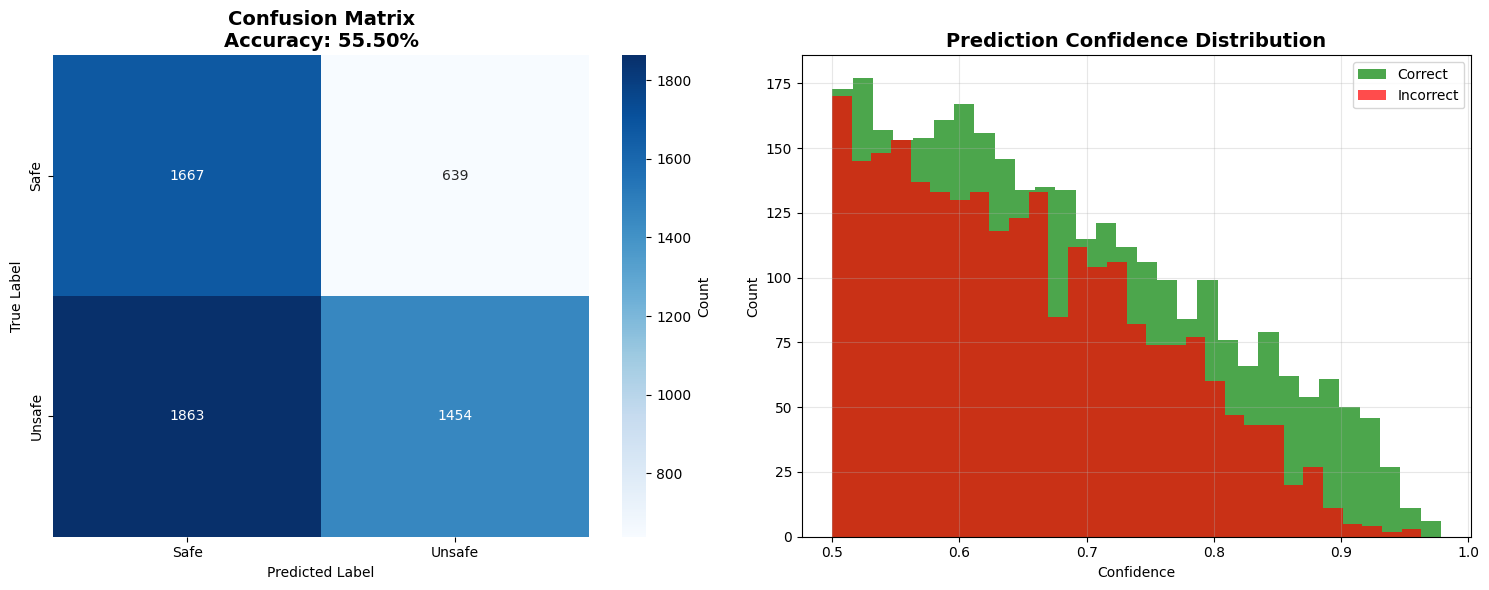

✅ Saved results to results/clip_baseline_results.png


In [6]:
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion matrix heatmap
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Safe', 'Unsafe'],
            yticklabels=['Safe', 'Unsafe'],
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Confidence distribution
ax2 = axes[1]
correct = test_df[test_df['label'] == test_df['prediction']]
incorrect = test_df[test_df['label'] != test_df['prediction']]

ax2.hist(correct['confidence'], bins=30, alpha=0.7, label='Correct', color='green')
ax2.hist(incorrect['confidence'], bins=30, alpha=0.7, label='Incorrect', color='red')
ax2.set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Confidence')
ax2.set_ylabel('Count')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/clip_baseline_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved results to results/clip_baseline_results.png")

In [7]:
# Analyze where model fails
print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

# False positives (predicted unsafe, actually safe)
false_positives = test_df[(test_df['label'] == 'safe') & (test_df['prediction'] == 'unsafe')]
print(f"\nFalse Positives: {len(false_positives)}")
print(f"Categories: {false_positives['category'].value_counts().to_dict()}")
print(f"Avg confidence: {false_positives['confidence'].mean():.4f}")

# False negatives (predicted safe, actually unsafe)
false_negatives = test_df[(test_df['label'] == 'unsafe') & (test_df['prediction'] == 'safe')]
print(f"\nFalse Negatives: {len(false_negatives)}")
print(f"Categories: {false_negatives['category'].value_counts().to_dict()}")
print(f"Avg confidence: {false_negatives['confidence'].mean():.4f}")

# Show some examples
print("\nSample False Positives (Safe → Unsafe):")
for idx, row in false_positives.head(3).iterrows():
    print(f"  - {Path(row['image_path']).name}: confidence={row['confidence']:.3f}")

print("\nSample False Negatives (Unsafe → Safe):")
for idx, row in false_negatives.head(3).iterrows():
    print(f"  - {Path(row['image_path']).name}: confidence={row['confidence']:.3f}")


ERROR ANALYSIS

False Positives: 639
Categories: {'neutral': 591, 'safe': 48}
Avg confidence: 0.6111

False Negatives: 1863
Categories: {'nsfw': 1861, 'violence': 2}
Avg confidence: 0.6631

Sample False Positives (Safe → Unsafe):
  - 19254_jpg.rf.8cf1ffda64a9a07d0d4963aab080580b.jpg: confidence=0.516
  - 14314_jpg.rf.8023c5e2e551fd4374715b8999516f42.jpg: confidence=0.599
  - 13283_jpg.rf.115fb969313c80ac17af6bd26df9c9df.jpg: confidence=0.550

Sample False Negatives (Unsafe → Safe):
  - cocaine_image02-12-_jpg.rf.4e09950aee7a401cf88d1ae2473aca9f.jpg: confidence=0.724
  - prefix_GantMan_8F9B9C8C-6A70-4BF4-A6B4-64E923B04798-jpg_jpeg.rf.4f015b6db145e38fea22b137d8358b50.jpg: confidence=0.787
  - cocaine_image8-2-_jpg.rf.bd0da1790190f0150918e6106e74f269.jpg: confidence=0.557


In [8]:
# Save results
results = {
    'model': model_name,
    'approach': 'zero-shot',
    'test_size': len(test_df),
    'accuracy': float(accuracy),
    'f1_score': float(f1),
    'precision_unsafe': float(tp/(tp+fp)),
    'recall_unsafe': float(tp/(tp+fn)),
    'confusion_matrix': cm.tolist(),
    'avg_confidence': float(test_df['confidence'].mean()),
    'false_positive_rate': float(fp / (fp + tn)),
    'false_negative_rate': float(fn / (fn + tp)),
}

with open('results/clip_baseline_metrics.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save predictions
test_df.to_csv('results/clip_baseline_predictions.csv', index=False)

print("\n✅ Saved metrics to results/clip_baseline_metrics.json")
print("✅ Saved predictions to results/clip_baseline_predictions.csv")

# Print final summary
print("\n" + "="*60)
print("BASELINE SUMMARY")
print("="*60)
print(f"Model: CLIP Zero-Shot (openai/clip-vit-base-patch32)")
print(f"Test Accuracy: {accuracy:.2%}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Confidence: {test_df['confidence'].mean():.2%}")
print("\nNext steps:")
print("1. Fine-tune CLIP on training data (expected: 85-90% accuracy)")
print("2. Add multi-task learning (violence, hate speech)")
print("3. Optimize for latency (quantization, TensorRT)")


✅ Saved metrics to results/clip_baseline_metrics.json
✅ Saved predictions to results/clip_baseline_predictions.csv

BASELINE SUMMARY
Model: CLIP Zero-Shot (openai/clip-vit-base-patch32)
Test Accuracy: 55.50%
F1 Score: 0.5375
Average Confidence: 66.39%

Next steps:
1. Fine-tune CLIP on training data (expected: 85-90% accuracy)
2. Add multi-task learning (violence, hate speech)
3. Optimize for latency (quantization, TensorRT)
